In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from object_detection.utils import metrics
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
tf.enable_eager_execution()


In [2]:
record_iterator = tf.python_io.tf_record_iterator(path='detections_test_5k_fold1.tfrecord')

t_precision= np.zeros(200)
t_recall= np.zeros(200)
t_fpr = np.zeros(201)
t_tpr = np.zeros(201)
AP = 0
t_roc_auc = 0

num_gt = 100
i=0
n=23
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    label = np.array(example.features.feature['image/detection/label'].int64_list.value)
    #print(label)
    #print(i)
    #i+=1
    #Change the class = "2" in label array into 0 for fitting with the built-in function
    label[label == 2] = 0
    label = np.array(label, dtype = bool)
    score = np.array(example.features.feature['image/detection/score'].float_list.value)
    #print(score.size)
    
    #calculate Precision & Recall (in numpy array type)
    precision, recall = metrics.compute_precision_recall(score, label, num_gt)
    average_precision = average_precision_score(label, score)
   
    fpr, tpr, _ = roc_curve(label, score, drop_intermediate=False)
    
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    
    AP = AP + average_precision
    t_precision=t_precision+precision
    t_recall=t_recall+recall
    
    if fpr.size != 201:
        n = n - 1
        continue
        
    t_fpr = t_fpr + fpr
    t_tpr = t_tpr + tpr
    t_roc_auc = t_roc_auc + roc_auc
    
t_precision = t_precision / n
t_recall = t_recall / n
AP = AP / n

t_fpr = t_fpr / n
#print(t_fpr)
t_tpr = t_tpr / n
#print(t_tpr)
t_roc_auc = t_roc_auc / n 
pd.DataFrame(t_precision, t_recall).to_csv("final_PR_data.csv")
pd.DataFrame(t_fpr, t_tpr).to_csv("final_ROC_data.csv")


0.27459999999999996
0.28750000000000003
0.27759999999999996
0.3057
0.27670000000000006
0.29179999999999995
0.2781
0.26849999999999996
0.3084
0.3064
0.3159
0.2716
0.3075
0.274
0.279
0.2946
0.315
0.2826
0.3038
0.30279999999999996
0.2743
0.3439
0.2866


Text(0.5, 1.0, 'PR curve - Fold 1 - 5.000 training steps: AP=0.42')

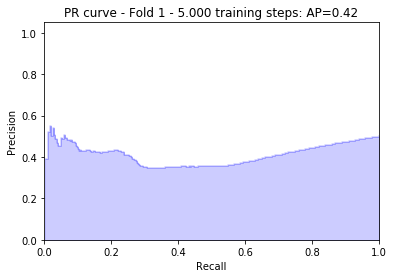

In [19]:
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(t_recall, t_precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(t_recall, t_precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve - Fold 1 - 5.000 training steps: AP={0:0.2f}'.format(AP))


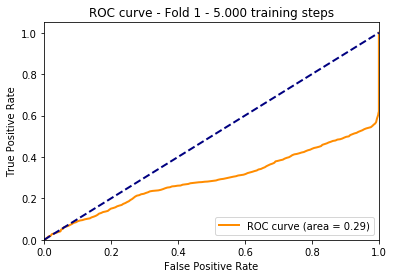

In [18]:
plt.figure()
lw = 2
plt.plot(t_fpr, t_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % t_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - Fold 1 - 5.000 training steps')
plt.legend(loc="lower right")
plt.show()